<h2 align = "center">Mod 8: Fine Tune</h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import latte
import latte.nn as nn
import latte.optim as optim
import latte.functional as F
import latte.utils.data as data

import lattevision as lv
import lattevision.datasets as dsets
import lattevision.transforms as T


In [2]:
mnist_root = './data/mnist'
mnist_transform = T.Compose([T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])

mnist_train = dsets.MNIST(mnist_root, train=True, transform=mnist_transform)
mnist_test = dsets.MNIST(mnist_root, train=False, transform=mnist_transform)

val_len = len(mnist_train) // 10
train_len = len(mnist_train) - val_len
mnist_train, mnist_val = data.random_split(mnist_train, [train_len, val_len])

# Batch sizes below should be equal in this framework due to broadcasting
train_batch_size = 128
test_batch_size = 512

train_loader = data.DataLoader(mnist_train, batch_size=train_batch_size, shuffle=True)
val_loader = data.DataLoader(mnist_val, batch_size=train_batch_size, shuffle=False)
test_loader = data.DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False)


In [3]:
class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


model = Model()
model_finetune = Model()
criterion = nn.MSELoss()
criterion_finetune = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0)
optimizer_finetune = optim.SGD(model_finetune.parameters(), lr=1e-2, momentum=0)


In [4]:
max_epochs = 15

train_losses = []
train_losses_finetune = []
train_accuracies = []
train_accuracies_finetune = []

val_losses = []
val_losses_finetune = []
val_accuracies = []
val_accuracies_finetune = []

for epoch in range(max_epochs):
    # Training
    epoch_loss = 0
    epoch_loss_finetune = 0
    epoch_accuracy = 0
    epoch_accuracy_finetune = 0
    epoch_batchs = 0

    for ii, (data, target) in enumerate(train_loader):
        batch_size = data.shape[0]
        if batch_size != train_batch_size:
            continue
        epoch_batchs += 1

        data = latte.Tensor(data.reshape(batch_size, -1))
        target_mse = np.zeros((batch_size, 10))
        target_mse[np.arange(batch_size), target] = 1
        target_mse = latte.Tensor(target_mse)

        # Forward pass
        optimizer.zero_grad()
        optimizer_finetune.zero_grad()
        output = model(data)
        output_finetune = model_finetune(data)

        # Compute loss
        loss = criterion(output, target_mse)
        epoch_loss += loss.data
        loss_finetune = criterion_finetune(output_finetune, target_mse)
        epoch_loss_finetune += loss_finetune.data

        # Backward pass
        loss.backward()
        optimizer.step()
        loss_finetune.backward()
        optimizer_finetune.step()

        # Compute accuracy
        accuracy = (output.data.argmax(axis=1) == target).mean()
        epoch_accuracy += accuracy
        accuracy_finetune = (output_finetune.data.argmax(axis=1) == target).mean()
        epoch_accuracy_finetune += accuracy_finetune

    # Logging
    train_losses.append(np.round(epoch_loss / epoch_batchs, 4))
    train_losses_finetune.append(np.round(epoch_loss_finetune / epoch_batchs, 4))
    train_accuracies.append(np.round(epoch_accuracy / epoch_batchs, 4))
    train_accuracies_finetune.append(
        np.round(epoch_accuracy_finetune / epoch_batchs, 4)
    )

    # * Fine tuning
    x_ft, y_ft = [], []
    for data, target in train_loader:
        batch_size = data.shape[0]
        if batch_size != train_batch_size:
            continue

        data = latte.Tensor(data.reshape(batch_size, -1))
        target_mse = np.zeros((batch_size, 10))
        target_mse[np.arange(batch_size), target] = 1
        target_mse = latte.Tensor(target_mse)

        data = model_finetune.fc1(data)
        data = model_finetune.relu(data)

        x_ft.append(data.data)
        y_ft.append(target_mse.data)

    fc2_bias_data = model_finetune.fc2.bias.data
    x_ft = np.concatenate(x_ft)
    y_ft = np.concatenate(y_ft)
    x_ft_mpinv = np.matmul(
        np.linalg.pinv(np.matmul(x_ft.T, x_ft)), x_ft.T
    )  # Moore-Penrose pseudoinverse
    fc2_weight_data = np.matmul(
        x_ft_mpinv, (y_ft - fc2_bias_data)
    )  # (X^T * X)^-1 * X^T * (Y - b)
    model_finetune.fc2.weight.data = fc2_weight_data

    # Validation
    epoch_loss = 0
    epoch_loss_finetune = 0
    epoch_accuracy = 0
    epoch_accuracy_finetune = 0
    epoch_batchs = 0

    for data, target in val_loader:
        batch_size = data.shape[0]
        if batch_size != train_batch_size:
            continue
        epoch_batchs += 1

        data = latte.Tensor(data.reshape(batch_size, -1))
        target_mse = np.zeros((batch_size, 10))
        target_mse[np.arange(batch_size), target] = 1
        target_mse = latte.Tensor(target_mse)

        output = model(data)
        output_finetune = model_finetune(data)

        # Compute loss
        loss = criterion(output, target_mse)
        epoch_loss += loss.data
        loss_finetune = criterion_finetune(output_finetune, target_mse)
        epoch_loss_finetune += loss_finetune.data

        # Compute accuracy
        accuracy = (output.data.argmax(axis=1) == target).mean()
        epoch_accuracy += accuracy
        accuracy_finetune = (output_finetune.data.argmax(axis=1) == target).mean()
        epoch_accuracy_finetune += accuracy_finetune

    # Logging
    val_losses.append(np.round(epoch_loss / epoch_batchs, 4))
    val_losses_finetune.append(np.round(epoch_loss_finetune / epoch_batchs, 4))
    val_accuracies.append(np.round(epoch_accuracy / epoch_batchs, 4))
    val_accuracies_finetune.append(np.round(epoch_accuracy_finetune / epoch_batchs, 4))

print('No FineTune:')
print('Training')
print(f'\tLoss: {train_losses}')
print(f'\tAccuracy: {train_accuracies}')
print('Validation')
print(f'\tLoss: {val_losses}')
print(f'\tAccuracy: {val_accuracies}')
print('FineTune:')
print('Training')
print(f'\tLoss: {train_losses_finetune}')
print(f'\tAccuracy: {train_accuracies_finetune}')
print('Validation')
print(f'\tLoss: {val_losses_finetune}')
print(f'\tAccuracy: {val_accuracies_finetune}')


No FineTune:
Training
	Loss: [0.0258, 0.0157, 0.0125, 0.0108, 0.0098, 0.0092, 0.0086, 0.0082, 0.0079, 0.0076, 0.0073, 0.0071, 0.0069, 0.0067, 0.0065]
	Accuracy: [0.772, 0.879, 0.9032, 0.915, 0.9227, 0.9284, 0.9343, 0.9387, 0.9419, 0.9451, 0.9476, 0.9503, 0.9523, 0.9541, 0.9557]
Validation
	Loss: [0.0181, 0.0136, 0.0114, 0.0102, 0.0094, 0.0088, 0.0084, 0.008, 0.0077, 0.0075, 0.0072, 0.007, 0.0069, 0.0067, 0.0066]
	Accuracy: [0.8632, 0.897, 0.912, 0.9219, 0.9293, 0.9345, 0.9373, 0.9406, 0.9444, 0.9457, 0.949, 0.9493, 0.9509, 0.9538, 0.9543]
FineTune:
Training
	Loss: [0.0259, 0.0103, 0.0079, 0.0069, 0.0063, 0.0058, 0.0055, 0.0052, 0.005, 0.0048, 0.0047, 0.0045, 0.0044, 0.0043, 0.0042]
	Accuracy: [0.7658, 0.9302, 0.9501, 0.9581, 0.9626, 0.9662, 0.9683, 0.9702, 0.9719, 0.9734, 0.9743, 0.9757, 0.9764, 0.9773, 0.9778]
Validation
	Loss: [0.0125, 0.0085, 0.0072, 0.0065, 0.006, 0.0057, 0.0054, 0.0052, 0.0051, 0.005, 0.0048, 0.0047, 0.0047, 0.0046, 0.0045]
	Accuracy: [0.912, 0.9448, 0.9556, 0.959

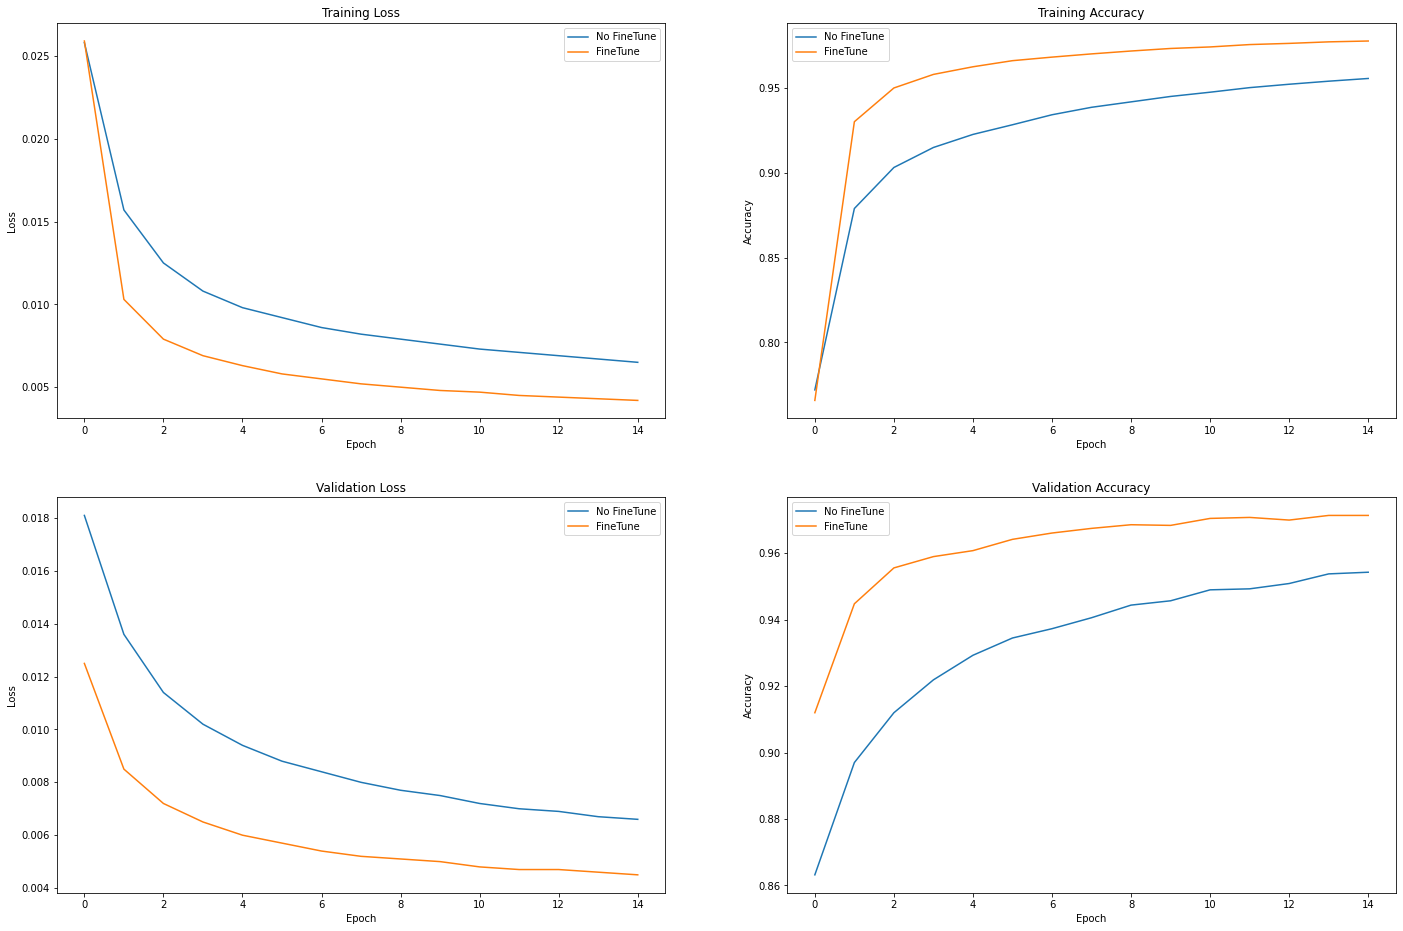

In [6]:
# Plot
plt.figure(figsize=(24, 16))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='No FineTune')
plt.plot(train_losses_finetune, label='FineTune')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='No FineTune')
plt.plot(train_accuracies_finetune, label='FineTune')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(val_losses, label='No FineTune')
plt.plot(val_losses_finetune, label='FineTune')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(val_accuracies, label='No FineTune')
plt.plot(val_accuracies_finetune, label='FineTune')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [7]:
# Test
correct = 0
correct_finetune = 0
total = 0
for data, target in test_loader:
    batch_size = data.shape[0]
    if batch_size != test_batch_size:
        continue

    data = latte.Tensor(data.reshape(batch_size, -1))
    target = latte.Tensor(target)

    output = model(data)
    output_finetune = model_finetune(data)
    correct += (output.data.argmax(axis=1) == target.data).sum()
    correct_finetune += (output_finetune.data.argmax(axis=1) == target.data).sum()
    total += target.shape[0]

print(f'Accuracy')
print(f'\tNo FineTune: {(correct / total): .4f}')
print(f'\tFineTune: {(correct_finetune / total): .4f}')


Accuracy
	No FineTune:  0.9583
	FineTune:  0.9711
